## Real or Not? NLP with Disaster Tweets

In this kernel you can find Basic EDA of Disaster Tweet dataset. Simple lemmatization using WordNetLemmatizer from nltk. Creation of dataset using torchtext. And LSTM implementation using PyTorch. Let's have some fun!

What's in this kernel?
* [Basic EDA](#EDA)
* [Data Cleaning](#Data-Cleaning)
* [PyTorch dataset](#PyTorch-dataset)
* [PyTorch Model](#PyTorch-Model)
* [PyTorch train](#PyTorch-train)
* [Predictions](#Predictions)

### Acknowledgments

1. [Basic EDA,Cleaning and GloVe](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Exploratory-Data-Analysis-of-tweets) - For such a great EDA and cleaning
2. [Text-Classification-Pytorch](https://github.com/prakashpandey9/Text-Classification-Pytorch) - For LSTM model

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


## Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import re
import string
import os
from collections import defaultdict
from collections import Counter

plt.style.use('ggplot')
stop = set(stopwords.words('english'))

import gensim
from tqdm.notebook import tqdm

In [3]:
sample_submission = pd.read_csv('C:/Users/14753/Documents/nlp project/sample_submission.csv')
test = pd.read_csv('C:/Users/14753/Documents/nlp project/test.csv')
train = pd.read_csv('C:/Users/14753/Documents/nlp project/train.csv')

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## EDA

In [5]:
train.loc[1]

id                                               4
keyword                                        NaN
location                                       NaN
text        Forest fire near La Ronge Sask. Canada
target                                           1
Name: 1, dtype: object

1 - real disaster
<br>
0 - no disaster

### Most common words

In [6]:
def create_corpus(target):
    corpus = []
    
    for x in train.loc[train['target'] == target, 'text'].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

<BarContainer object of 10 artists>

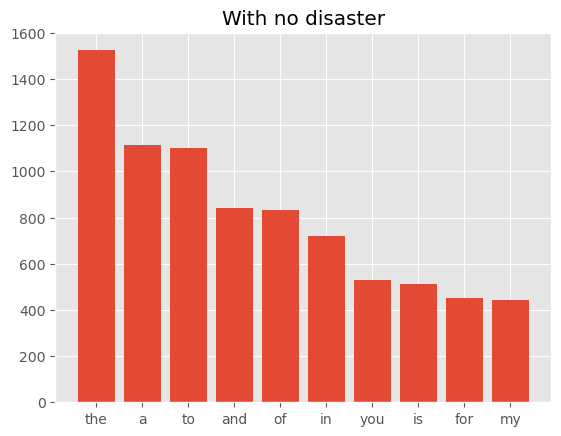

In [7]:
corpus = create_corpus(0)

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1
        
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

x, y = zip(*top)
plt.title('With no disaster')
plt.bar(x, y)

The main words are articles. It makes sense.

<BarContainer object of 10 artists>

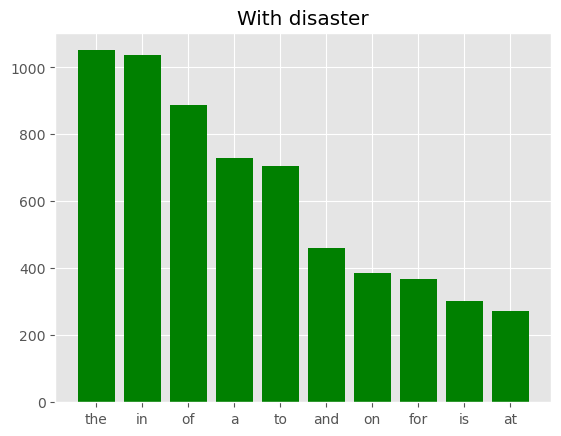

In [8]:
corpus = create_corpus(1)

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1
        
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

x, y = zip(*top)

plt.title('With disaster')
plt.bar(x, y, color='green')

Now <i>in</i> is almost on the first plays. During disaster we try to explain where is it.

### Punctuation

<BarContainer object of 20 artists>

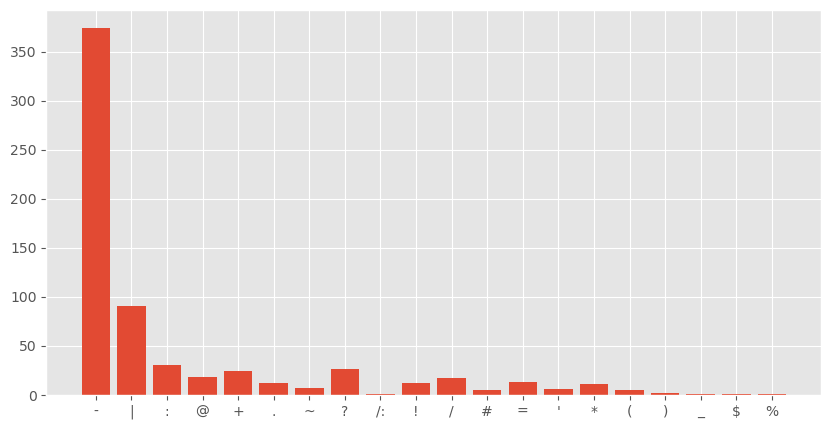

In [9]:
plt.figure(figsize=(10, 5))
corpus = create_corpus(0)

dic = defaultdict(int)

special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1
        
x, y = zip(*dic.items())
plt.bar(x, y)

<BarContainer object of 20 artists>

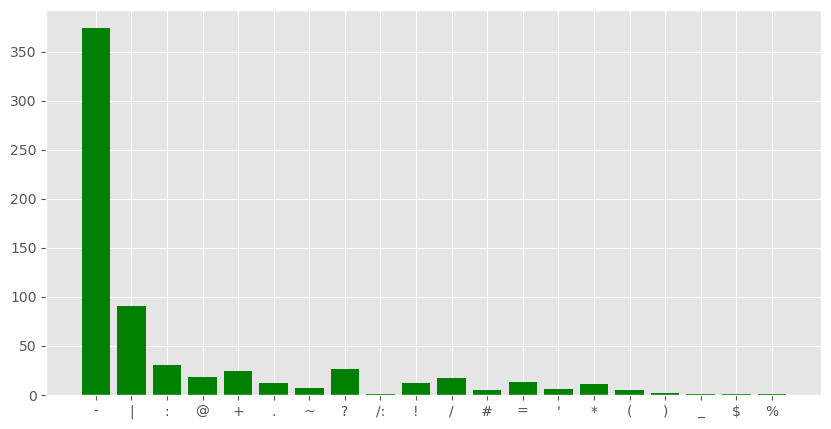

In [10]:
plt.figure(figsize=(10, 5))
corpus = create_corpus(0)

dic = defaultdict(int)

special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1
        
x, y = zip(*dic.items())
plt.bar(x, y, color='green')

Punctuation is almost the same. Maybe we can delete it.

<Axes: >

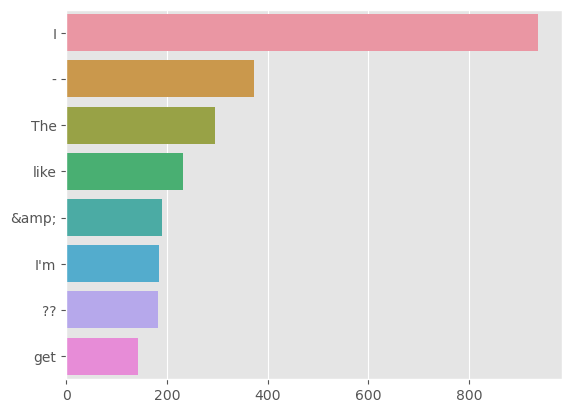

In [11]:
counter = Counter(corpus)
most_common = counter.most_common()

x = list()
y = list()

for word, count in most_common[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)
        
sns.barplot(x=y, y=x, orient='h')

### Bigrams

In [12]:
def get_top_tweet_bigrams(corpus, n=10):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

<Axes: >

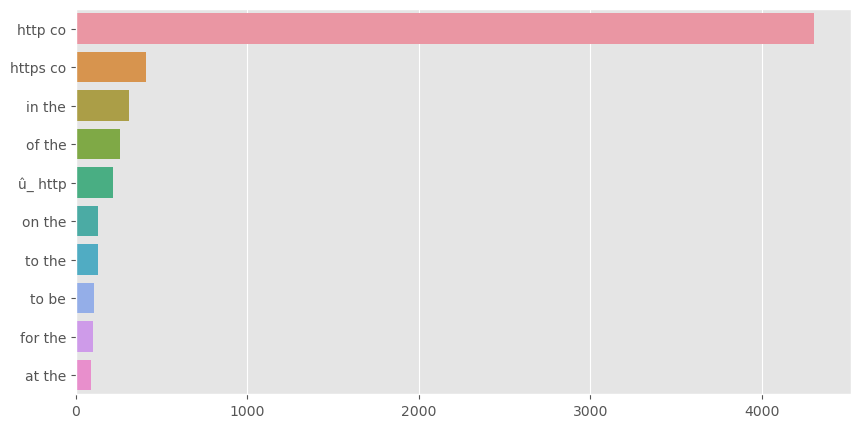

In [13]:
plt.figure(figsize=(10, 5))
top_tweet_bigrams = get_top_tweet_bigrams(train['text'])[:10]

x, y = map(list, zip(*top_tweet_bigrams))

sns.barplot(x=y, y=x)

## Data Cleaning

Let's concatenate <i>train</i> and <i>test</i> datasets.

In [14]:
df = pd.concat([train, test])
df.shape

(10876, 5)

We can remove URLs, HTML tags and emojis. It is hard to get information from them.

In [15]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    
    return url.sub('', text)

example = 'New competition launched: https://www.kaggle.com/c/nlp-getting-started'

remove_URL(example)

'New competition launched: '

In [16]:
df['text'] = df['text'].apply(lambda x: remove_URL(x))

In [17]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [18]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    
    return html.sub('', text)

print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [19]:
df['text'] = df['text'].apply(lambda x: remove_html(x))

In [20]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)


remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [21]:
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

In [22]:
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    
    return text.translate(table)

example = "I am #king"
print(remove_punct(example))

I am king


In [23]:
df['text'] = df['text'].apply(lambda x: remove_punct(x))

Good thing to do is [lemmatizing](https://en.wikipedia.org/wiki/Lemmatisation). We can do it using [nltk](http://www.nltk.org/book/) library.

> Lemmatization in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

In [24]:
keywords = train.keyword.unique()[1:]
keywords = list(map(lambda x: x.replace('%20', ' '), keywords))

wnl = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    sentence_words = sentence.split(' ')
    new_sentence_words = list()
    
    for sentence_word in sentence_words:
        sentence_word = sentence_word.replace('#', '')
        new_sentence_word = wnl.lemmatize(sentence_word.lower(), wordnet.VERB)
        new_sentence_words.append(new_sentence_word)
        
    new_sentence = ' '.join(new_sentence_words)
    new_sentence = new_sentence.strip()
    
    return new_sentence

In [25]:
df['text'] = df['text'].apply(lambda x: lemmatize_sentence(x))

## PyTorch

In [26]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable

from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

## PyTorch dataset

If we want to use torchtext we should save <i>train</i>, <i>test</i> and </i>validation</i> datasets into separated files.

In [27]:
def prepare_csv(df_train, df_test, seed=27, val_ratio=0.3):
    idx = np.arange(df_train.shape[0])
    
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    val_size = int(len(idx) * val_ratio)
    
    if not os.path.exists('cache'):
        os.makedirs('cache')
    
    df_train.iloc[idx[val_size:], :][['id', 'target', 'text']].to_csv(
        'cache/dataset_train.csv', index=False
    )
    
    df_train.iloc[idx[:val_size], :][['id', 'target', 'text']].to_csv(
        'cache/dataset_val.csv', index=False
    )
    
    df_test[['id', 'text']].to_csv('cache/dataset_test.csv',
                   index=False)

Method for wrapping TabularDataset into iterator. So, we can iterate threw dataset.

In [28]:
def get_iterator(dataset, batch_size, train=True,
                 shuffle=True, repeat=False):
    
    device = torch.device('cuda:0' if torch.cuda.is_available()
                          else 'cpu')
    
    dataset_iter = data.Iterator(
        dataset, batch_size=batch_size, device=device,
        train=train, shuffle=shuffle, repeat=repeat,
        sort=False
    )
    
    return dataset_iter

For embeddings we are using [GloVe](https://github.com/maciejkula/glove-python):

> Glove produces dense vector embeddings of words, where words that occur together are close in the resulting vector space.
> <br><br> While this produces embeddings which are similar to word2vec (which has a great python implementation in gensim), the method is different: GloVe produces embeddings by factorizing the logarithm of the corpus word co-occurrence matrix.

In [29]:
import logging
from copy import deepcopy

LOGGER = logging.getLogger('tweets_dataset')

def get_dataset(fix_length=100, lower=False, vectors=None):
    
    if vectors is not None:
        lower=True
        
    LOGGER.debug('Preparing CSV files...')
    prepare_csv(train, test)
    
    TEXT = data.Field(sequential=True, 
#                       tokenize='spacy', 
                      lower=True, 
                      include_lengths=True, 
                      batch_first=True, 
                      fix_length=25)
    LABEL = data.Field(use_vocab=True,
                       sequential=False,
                       dtype=torch.float16)
    ID = data.Field(use_vocab=False,
                    sequential=False,
                    dtype=torch.float16)
    
    
    LOGGER.debug('Reading train csv files...')
    
    train_temp, val_temp = data.TabularDataset.splits(
        path='cache/', format='csv', skip_header=True,
        train='dataset_train.csv', validation='dataset_val.csv',
        fields=[
            ('id', ID),
            ('target', LABEL),
            ('text', TEXT)
        ]
    )
    
    LOGGER.debug('Reading test csv file...')
    
    test_temp = data.TabularDataset(
        path='cache/dataset_test.csv', format='csv',
        skip_header=True,
        fields=[
            ('id', ID),
            ('text', TEXT)
        ]
    )
    
    LOGGER.debug('Building vocabulary...')
    
    TEXT.build_vocab(
        train_temp, val_temp, test_temp,
        max_size=20000,
        min_freq=10,
        vectors=GloVe(name='6B', dim=300)  # We use it for getting vocabulary of words
    )
    LABEL.build_vocab(
        train_temp
    )
    ID.build_vocab(
        train_temp, val_temp, test_temp
    )
    
    word_embeddings = TEXT.vocab.vectors
    vocab_size = len(TEXT.vocab)
    
    train_iter = get_iterator(train_temp, batch_size=32, 
                              train=True, shuffle=True,
                              repeat=False)
    val_iter = get_iterator(val_temp, batch_size=32, 
                            train=True, shuffle=True,
                            repeat=False)
    test_iter = get_iterator(test_temp, batch_size=32, 
                             train=False, shuffle=False,
                             repeat=False)
    
    
    LOGGER.debug('Done preparing the datasets')
    
    return TEXT, vocab_size, word_embeddings, train_iter, val_iter, test_iter

In [30]:
TEXT, vocab_size, word_embeddings, train_iter, val_iter, test_iter = get_dataset()

## PyTorch Model

For this task we will try to use LSTM network.

In [31]:
class LSTMClassifier(torch.nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, weights):
        super(LSTMClassifier, self).__init__()
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.word_embeddings = torch.nn.Embedding(vocab_size,
                                                  embedding_dim)
        self.word_embeddings.weight = torch.nn.Parameter(weights,
                                                         requires_grad=False)
        
        self.dropout_1 = torch.nn.Dropout(0.3)
        self.lstm = torch.nn.LSTM(embedding_dim,
                                  hidden_dim,
                                  n_layers,
                                  dropout=0.3,
                                  batch_first=True)
        
        self.dropout_2 = torch.nn.Dropout(0.3)
        self.label_layer = torch.nn.Linear(hidden_dim, output_size)
        
        self.act = torch.nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        
        x = self.word_embeddings(x)
        
        x = self.dropout_1(x)
        
        lstm_out, hidden = self.lstm(x, hidden)
                
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout_2(lstm_out)
        out = self.label_layer(out)    
        
        out = out.view(batch_size, -1, self.output_size)
        out = out[:, -1, :]

        out = self.act(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        
        return hidden

## PyTorch train

Method for network training. 

In [32]:
def train_model(model, train_iter, val_iter, optim, loss, num_epochs, batch_size=32):
    h = model.init_hidden(batch_size)
    
    clip = 5
    val_loss_min = np.Inf
    
    total_train_epoch_loss = list()
    total_train_epoch_acc = list()
        
    total_val_epoch_loss = list()
    total_val_epoch_acc = list()
        
    
    device = torch.device('cuda:0' if torch.cuda.is_available()
                           else 'cpu')
    
    for epoch in range(num_epochs):

        model.train()
        
        train_epoch_loss = list()
        train_epoch_acc = list()
        
        val_epoch_loss = list()
        val_epoch_acc = list()
        
        for idx, batch in enumerate(tqdm(train_iter)):
            h = tuple([e.data for e in h])

            text = batch.text[0]
            target = batch.target
            target = target - 1
            target = target.type(torch.LongTensor)

            text = text.to(device)
            target = target.to(device)

            optim.zero_grad()
            
            if text.size()[0] is not batch_size:
                continue
            
            prediction, h = model(text, h)
                
            loss_train = loss(prediction.squeeze(), target)
            loss_train.backward()

            num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

            acc = 100.0 * num_corrects / len(batch)

            train_epoch_loss.append(loss_train.item())
            train_epoch_acc.append(acc.item())
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            optim.step()
    
        print(f'Train Epoch: {epoch}, Training Loss: {np.mean(train_epoch_loss):.4f}, Training Accuracy: {np.mean(train_epoch_acc): .2f}%')

        model.eval()

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_iter)):
                val_h = tuple([e.data for e in h])

                text = batch.text[0]
                target = batch.target
                target = target - 1
                target = target.type(torch.LongTensor)
                
                text = text.to(device)
                target = target.to(device)
                
                if text.size()[0] is not batch_size:
                    continue

                prediction, h = model(text, h)
                loss_val = loss(prediction.squeeze(), target)

                num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

                acc = 100.0 * num_corrects / len(batch)

                val_epoch_loss.append(loss_val.item())
                val_epoch_acc.append(acc.item())
                
            print(f'Vadlidation Epoch: {epoch}, Training Loss: {np.mean(val_epoch_loss):.4f}, Training Accuracy: {np.mean(val_epoch_acc): .2f}%')
                
            if np.mean(val_epoch_loss) <= val_loss_min:
#                 torch.save(model.state_dict(), 'state_dict.pth')
                print('Validation loss decreased ({:.6f} --> {:.6f})'.
                      format(val_loss_min, np.mean(val_epoch_loss)))
                
                val_loss_min = np.mean(val_epoch_loss)
                
        total_train_epoch_loss.append(np.mean(train_epoch_loss))
        total_train_epoch_acc.append(np.mean(train_epoch_acc))
    
        total_val_epoch_loss.append(np.mean(val_epoch_loss))
        total_val_epoch_acc.append(np.mean(val_epoch_acc))
    
    return (total_train_epoch_loss, total_train_epoch_acc,
            total_val_epoch_loss, total_val_epoch_acc)

In [33]:
lr = 1e-4
batch_size = 32
output_size = 2
hidden_size = 128
embedding_length = 300

model = LSTMClassifier(vocab_size=vocab_size, 
                       output_size=output_size, 
                       embedding_dim=embedding_length,
                       hidden_dim=hidden_size,
                       n_layers=2,
                       weights=word_embeddings
)

device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')
    
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()
    
train_loss, train_acc, val_loss, val_acc = train_model(model=model,
                                                       train_iter=train_iter,
                                                       val_iter=val_iter,
                                                       optim=optim,
                                                       loss=loss,
                                                       num_epochs=20,
                                                       batch_size=batch_size)
    

  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 0, Training Loss: 0.6813, Training Accuracy:  57.64%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 0, Training Loss: 0.6530, Training Accuracy:  55.59%
Validation loss decreased (inf --> 0.652980)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 1, Training Loss: 0.6209, Training Accuracy:  64.61%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 1, Training Loss: 0.6119, Training Accuracy:  69.19%
Validation loss decreased (0.652980 --> 0.611869)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 2, Training Loss: 0.5684, Training Accuracy:  74.23%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 2, Training Loss: 0.5642, Training Accuracy:  74.34%
Validation loss decreased (0.611869 --> 0.564155)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 3, Training Loss: 0.5457, Training Accuracy:  76.24%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 3, Training Loss: 0.5569, Training Accuracy:  74.60%
Validation loss decreased (0.564155 --> 0.556896)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 4, Training Loss: 0.5342, Training Accuracy:  77.47%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 4, Training Loss: 0.5530, Training Accuracy:  75.09%
Validation loss decreased (0.556896 --> 0.552992)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 5, Training Loss: 0.5278, Training Accuracy:  77.90%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 5, Training Loss: 0.5523, Training Accuracy:  75.35%
Validation loss decreased (0.552992 --> 0.552333)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 6, Training Loss: 0.5227, Training Accuracy:  78.45%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 6, Training Loss: 0.5410, Training Accuracy:  76.85%
Validation loss decreased (0.552333 --> 0.540999)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 7, Training Loss: 0.5241, Training Accuracy:  78.03%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 7, Training Loss: 0.5379, Training Accuracy:  76.63%
Validation loss decreased (0.540999 --> 0.537874)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 8, Training Loss: 0.5215, Training Accuracy:  78.35%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 8, Training Loss: 0.5494, Training Accuracy:  75.22%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 9, Training Loss: 0.5222, Training Accuracy:  78.45%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 9, Training Loss: 0.5418, Training Accuracy:  76.32%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 10, Training Loss: 0.5229, Training Accuracy:  77.90%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 10, Training Loss: 0.5410, Training Accuracy:  75.84%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 11, Training Loss: 0.5167, Training Accuracy:  78.46%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 11, Training Loss: 0.5373, Training Accuracy:  77.07%
Validation loss decreased (0.537874 --> 0.537314)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 12, Training Loss: 0.5104, Training Accuracy:  79.54%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 12, Training Loss: 0.5383, Training Accuracy:  76.67%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 13, Training Loss: 0.5088, Training Accuracy:  79.76%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 13, Training Loss: 0.5357, Training Accuracy:  77.24%
Validation loss decreased (0.537314 --> 0.535657)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 14, Training Loss: 0.5128, Training Accuracy:  79.27%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 14, Training Loss: 0.5349, Training Accuracy:  77.29%
Validation loss decreased (0.535657 --> 0.534948)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 15, Training Loss: 0.5114, Training Accuracy:  79.57%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 15, Training Loss: 0.5347, Training Accuracy:  76.63%
Validation loss decreased (0.534948 --> 0.534687)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 16, Training Loss: 0.5097, Training Accuracy:  79.50%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 16, Training Loss: 0.5322, Training Accuracy:  76.89%
Validation loss decreased (0.534687 --> 0.532198)


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 17, Training Loss: 0.5088, Training Accuracy:  79.37%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 17, Training Loss: 0.5392, Training Accuracy:  76.72%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 18, Training Loss: 0.5072, Training Accuracy:  79.73%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 18, Training Loss: 0.5376, Training Accuracy:  76.80%


  0%|          | 0/167 [00:00<?, ?it/s]

Train Epoch: 19, Training Loss: 0.5059, Training Accuracy:  80.16%


  0%|          | 0/72 [00:00<?, ?it/s]

Vadlidation Epoch: 19, Training Loss: 0.5352, Training Accuracy:  76.67%


for this LSTM model traing loss and accuracy "Training Loss: 0.5059, Training Accuracy:  80.16%"

For this task we will try to use stacked LSTM network.

In [34]:
import torch
import numpy as np
from tqdm import tqdm

class StackedLSTMClassifier(torch.nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, weights):
        super(StackedLSTMClassifier, self).__init__()
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight = torch.nn.Parameter(weights, requires_grad=False)
        
        self.dropout = torch.nn.Dropout(0.3)
        
        # Stacked LSTM layers
        self.lstms = torch.nn.ModuleList([
            torch.nn.LSTM(embedding_dim if i == 0 else hidden_dim,
                          hidden_dim,
                          num_layers=1,
                          dropout=0.3,
                          batch_first=True)
            for i in range(n_layers)
        ])
        
        self.label_layer = torch.nn.Linear(hidden_dim, output_size)
        self.act = torch.nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        
        x = self.word_embeddings(x)
        x = self.dropout(x)
        
        # Pass through stacked LSTM layers
        for i, lstm in enumerate(self.lstms):
            x, hidden = lstm(x if i == 0 else x_out, hidden)
            x_out = x.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(x_out)
        out = self.label_layer(out)    
        
        out = out.view(batch_size, -1, self.output_size)
        out = out[:, -1, :]

        out = self.act(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        
        return hidden

# Example usage:
# Initialize the stacked LSTM model
vocab_size = 10000  # Replace with your vocabulary size
output_size = 5  # Replace with the number of output classes
embedding_dim = 100  # Replace with the desired embedding dimension
hidden_dim = 128  # Replace with the desired hidden layer dimension
n_layers = 2  # Number of LSTM layers
weights = torch.randn(vocab_size, embedding_dim)  # Example weights, replace with actual embeddings

model = StackedLSTMClassifier(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, weights)

# Example usage of training the stacked LSTM model
# Replace train_iter, val_iter, optim, loss, num_epochs with your actual data and training configurations
# train_model(model, train_iter, val_iter, optim, loss, num_epochs, batch_size=32)


C:\Users\14753\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [35]:
def train_model(model, train_iter, val_iter, optim, loss, num_epochs, batch_size=32):
    h = model.init_hidden(batch_size)
    
    clip = 5
    val_loss_min = np.Inf
    
    total_train_epoch_loss = list()
    total_train_epoch_acc = list()
        
    total_val_epoch_loss = list()
    total_val_epoch_acc = list()
        
    
    device = torch.device('cuda:0' if torch.cuda.is_available()
                           else 'cpu')
    
    for epoch in range(num_epochs):

        model.train()
        
        train_epoch_loss = list()
        train_epoch_acc = list()
        
        val_epoch_loss = list()
        val_epoch_acc = list()
        
        for idx, batch in enumerate(tqdm(train_iter)):
            h = tuple([e.data for e in h])

            text = batch.text[0]
            target = batch.target
            target = target - 1
            target = target.type(torch.LongTensor)

            text = text.to(device)
            target = target.to(device)

            optim.zero_grad()
            
            if text.size()[0] is not batch_size:
                continue
            
            prediction, h = model(text, h)
                
            loss_train = loss(prediction.squeeze(), target)
            loss_train.backward()

            num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

            acc = 100.0 * num_corrects / len(batch)

            train_epoch_loss.append(loss_train.item())
            train_epoch_acc.append(acc.item())
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            optim.step()
    
        print(f'Train Epoch: {epoch}, Training Loss: {np.mean(train_epoch_loss):.4f}, Training Accuracy: {np.mean(train_epoch_acc): .2f}%')

        model.eval()

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_iter)):
                val_h = tuple([e.data for e in h])

                text = batch.text[0]
                target = batch.target
                target = target - 1
                target = target.type(torch.LongTensor)
                
                text = text.to(device)
                target = target.to(device)
                
                if text.size()[0] is not batch_size:
                    continue

                prediction, h = model(text, h)
                loss_val = loss(prediction.squeeze(), target)

                num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

                acc = 100.0 * num_corrects / len(batch)

                val_epoch_loss.append(loss_val.item())
                val_epoch_acc.append(acc.item())
                
            print(f'Vadlidation Epoch: {epoch}, Training Loss: {np.mean(val_epoch_loss):.4f}, Training Accuracy: {np.mean(val_epoch_acc): .2f}%')
                
            if np.mean(val_epoch_loss) <= val_loss_min:
#                 torch.save(model.state_dict(), 'state_dict.pth')
                print('Validation loss decreased ({:.6f} --> {:.6f})'.
                      format(val_loss_min, np.mean(val_epoch_loss)))
                
                val_loss_min = np.mean(val_epoch_loss)
                
        total_train_epoch_loss.append(np.mean(train_epoch_loss))
        total_train_epoch_acc.append(np.mean(train_epoch_acc))
    
        total_val_epoch_loss.append(np.mean(val_epoch_loss))
        total_val_epoch_acc.append(np.mean(val_epoch_acc))
    
    return (total_train_epoch_loss, total_train_epoch_acc,
            total_val_epoch_loss, total_val_epoch_acc)

In [37]:
lr = 1e-4
batch_size = 32
output_size = 2
hidden_size = 128
embedding_length = 300

model = StackedLSTMClassifier(vocab_size=vocab_size, 
                       output_size=output_size, 
                       embedding_dim=embedding_length,
                       hidden_dim=hidden_size,
                       n_layers=2,
                       weights=word_embeddings
)

device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')
    
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()
    
train_loss, train_acc, val_loss, val_acc = train_model(model=model,
                                                       train_iter=train_iter,
                                                       val_iter=val_iter,
                                                       optim=optim,
                                                       loss=loss,
                                                       num_epochs=20,
                                                       batch_size=batch_size)
    

100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 63.53it/s]


Train Epoch: 0, Training Loss: 0.6777, Training Accuracy:  57.21%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 165.29it/s]


Vadlidation Epoch: 0, Training Loss: 0.7037, Training Accuracy:  55.81%
Validation loss decreased (inf --> 0.703741)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 83.51it/s]


Train Epoch: 1, Training Loss: 0.6126, Training Accuracy:  67.24%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 177.42it/s]


Vadlidation Epoch: 1, Training Loss: 0.5972, Training Accuracy:  73.68%
Validation loss decreased (0.703741 --> 0.597226)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 85.20it/s]


Train Epoch: 2, Training Loss: 0.5643, Training Accuracy:  75.24%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 221.40it/s]


Vadlidation Epoch: 2, Training Loss: 0.5679, Training Accuracy:  74.21%
Validation loss decreased (0.597226 --> 0.567887)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 85.18it/s]


Train Epoch: 3, Training Loss: 0.5418, Training Accuracy:  76.84%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 218.07it/s]


Vadlidation Epoch: 3, Training Loss: 0.5626, Training Accuracy:  73.42%
Validation loss decreased (0.567887 --> 0.562554)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 74.27it/s]


Train Epoch: 4, Training Loss: 0.5358, Training Accuracy:  76.81%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 183.16it/s]


Vadlidation Epoch: 4, Training Loss: 0.5545, Training Accuracy:  75.31%
Validation loss decreased (0.562554 --> 0.554488)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 77.38it/s]


Train Epoch: 5, Training Loss: 0.5270, Training Accuracy:  78.11%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 213.03it/s]


Vadlidation Epoch: 5, Training Loss: 0.5678, Training Accuracy:  73.28%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 82.98it/s]


Train Epoch: 6, Training Loss: 0.5289, Training Accuracy:  77.50%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 220.67it/s]


Vadlidation Epoch: 6, Training Loss: 0.5561, Training Accuracy:  74.34%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 78.31it/s]


Train Epoch: 7, Training Loss: 0.5231, Training Accuracy:  78.09%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 162.43it/s]


Vadlidation Epoch: 7, Training Loss: 0.5440, Training Accuracy:  75.44%
Validation loss decreased (0.554488 --> 0.544013)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 66.01it/s]


Train Epoch: 8, Training Loss: 0.5214, Training Accuracy:  78.11%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 192.93it/s]


Vadlidation Epoch: 8, Training Loss: 0.5385, Training Accuracy:  75.84%
Validation loss decreased (0.544013 --> 0.538506)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 80.63it/s]


Train Epoch: 9, Training Loss: 0.5179, Training Accuracy:  78.97%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 213.04it/s]


Vadlidation Epoch: 9, Training Loss: 0.5422, Training Accuracy:  76.19%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 84.63it/s]


Train Epoch: 10, Training Loss: 0.5152, Training Accuracy:  78.63%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 241.33it/s]


Vadlidation Epoch: 10, Training Loss: 0.5341, Training Accuracy:  76.80%
Validation loss decreased (0.538506 --> 0.534116)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 86.35it/s]


Train Epoch: 11, Training Loss: 0.5151, Training Accuracy:  78.82%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 227.57it/s]


Vadlidation Epoch: 11, Training Loss: 0.5370, Training Accuracy:  76.41%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 85.46it/s]


Train Epoch: 12, Training Loss: 0.5096, Training Accuracy:  79.48%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 222.65it/s]


Vadlidation Epoch: 12, Training Loss: 0.5351, Training Accuracy:  76.58%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 85.69it/s]


Train Epoch: 13, Training Loss: 0.5129, Training Accuracy:  79.41%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 205.57it/s]


Vadlidation Epoch: 13, Training Loss: 0.5369, Training Accuracy:  76.36%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 70.28it/s]


Train Epoch: 14, Training Loss: 0.5103, Training Accuracy:  79.27%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 205.58it/s]


Vadlidation Epoch: 14, Training Loss: 0.5338, Training Accuracy:  76.36%
Validation loss decreased (0.534116 --> 0.533755)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 80.40it/s]


Train Epoch: 15, Training Loss: 0.5070, Training Accuracy:  79.91%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 211.80it/s]


Vadlidation Epoch: 15, Training Loss: 0.5318, Training Accuracy:  77.11%
Validation loss decreased (0.533755 --> 0.531809)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 83.09it/s]


Train Epoch: 16, Training Loss: 0.5085, Training Accuracy:  79.52%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 200.68it/s]


Vadlidation Epoch: 16, Training Loss: 0.5354, Training Accuracy:  76.85%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 80.28it/s]


Train Epoch: 17, Training Loss: 0.5058, Training Accuracy:  79.69%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 210.23it/s]


Vadlidation Epoch: 17, Training Loss: 0.5317, Training Accuracy:  77.11%
Validation loss decreased (0.531809 --> 0.531692)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 83.06it/s]


Train Epoch: 18, Training Loss: 0.5003, Training Accuracy:  80.69%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 204.01it/s]


Vadlidation Epoch: 18, Training Loss: 0.5337, Training Accuracy:  76.67%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 83.26it/s]


Train Epoch: 19, Training Loss: 0.5021, Training Accuracy:  80.38%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 213.26it/s]

Vadlidation Epoch: 19, Training Loss: 0.5394, Training Accuracy:  76.54%


for this stacked LSTM training loss and acuuracy "Training Loss: 0.5003, Training Accuracy:  80.69%"

For this task we will try to use bidirectional LSTM network.

In [39]:
import torch
import torch.nn as nn

class BidirectionalLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, weights):
        super(BidirectionalLSTMClassifier, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False)

        self.dropout_1 = nn.Dropout(0.3)

        # Bidirectional LSTM layer
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=0.3, batch_first=True, bidirectional=True)

        self.dropout_2 = nn.Dropout(0.3)
        self.label_layer = nn.Linear(hidden_dim * 2, output_size)  # Multiply by 2 for bidirectional

        self.act = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        x = self.word_embeddings(x)
        x = self.dropout_1(x)

        # Bidirectional LSTM layer forward pass
        lstm_out, _ = self.bilstm(x)

        # Concatenate the hidden states from both directions
        lstm_out = torch.cat((lstm_out[:, -1, :self.hidden_dim], lstm_out[:, 0, self.hidden_dim:]), dim=1)

        out = self.dropout_2(lstm_out)
        out = self.label_layer(out)
        out = self.act(out)

        return out, None  # No hidden states returned in BiLSTM

    def init_hidden(self, batch_size):
        # No need for hidden states initialization in BiLSTM
        return None


In [40]:
def train_model(model, train_iter, val_iter, optim, loss, num_epochs, batch_size=32):
    h = model.init_hidden(batch_size)
    
    clip = 5
    val_loss_min = np.Inf
    
    total_train_epoch_loss = list()
    total_train_epoch_acc = list()
        
    total_val_epoch_loss = list()
    total_val_epoch_acc = list()
        
    
    device = torch.device('cuda:0' if torch.cuda.is_available()
                           else 'cpu')
    
    for epoch in range(num_epochs):

        model.train()
        
        train_epoch_loss = list()
        train_epoch_acc = list()
        
        val_epoch_loss = list()
        val_epoch_acc = list()
        
        for idx, batch in enumerate(tqdm(train_iter)):
            h = tuple([e.data for e in h])

            text = batch.text[0]
            target = batch.target
            target = target - 1
            target = target.type(torch.LongTensor)

            text = text.to(device)
            target = target.to(device)

            optim.zero_grad()
            
            if text.size()[0] is not batch_size:
                continue
            
            prediction, h = model(text, h)
                
            loss_train = loss(prediction.squeeze(), target)
            loss_train.backward()

            num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

            acc = 100.0 * num_corrects / len(batch)

            train_epoch_loss.append(loss_train.item())
            train_epoch_acc.append(acc.item())
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            optim.step()
    
        print(f'Train Epoch: {epoch}, Training Loss: {np.mean(train_epoch_loss):.4f}, Training Accuracy: {np.mean(train_epoch_acc): .2f}%')

        model.eval()

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_iter)):
                val_h = tuple([e.data for e in h])

                text = batch.text[0]
                target = batch.target
                target = target - 1
                target = target.type(torch.LongTensor)
                
                text = text.to(device)
                target = target.to(device)
                
                if text.size()[0] is not batch_size:
                    continue

                prediction, h = model(text, h)
                loss_val = loss(prediction.squeeze(), target)

                num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

                acc = 100.0 * num_corrects / len(batch)

                val_epoch_loss.append(loss_val.item())
                val_epoch_acc.append(acc.item())
                
            print(f'Vadlidation Epoch: {epoch}, Training Loss: {np.mean(val_epoch_loss):.4f}, Training Accuracy: {np.mean(val_epoch_acc): .2f}%')
                
            if np.mean(val_epoch_loss) <= val_loss_min:
#                 torch.save(model.state_dict(), 'state_dict.pth')
                print('Validation loss decreased ({:.6f} --> {:.6f})'.
                      format(val_loss_min, np.mean(val_epoch_loss)))
                
                val_loss_min = np.mean(val_epoch_loss)
                
        total_train_epoch_loss.append(np.mean(train_epoch_loss))
        total_train_epoch_acc.append(np.mean(train_epoch_acc))
    
        total_val_epoch_loss.append(np.mean(val_epoch_loss))
        total_val_epoch_acc.append(np.mean(val_epoch_acc))
    
    return (total_train_epoch_loss, total_train_epoch_acc,
            total_val_epoch_loss, total_val_epoch_acc)

In [41]:
lr = 1e-4
batch_size = 32
output_size = 2
hidden_size = 128
embedding_length = 300

model = BidirectionalLSTMClassifier(vocab_size=vocab_size, 
                       output_size=output_size, 
                       embedding_dim=embedding_length,
                       hidden_dim=hidden_size,
                       n_layers=2,
                       weights=word_embeddings
)

device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')
    
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()
    
train_loss, train_acc, val_loss, val_acc = train_model(model=model,
                                                       train_iter=train_iter,
                                                       val_iter=val_iter,
                                                       optim=optim,
                                                       loss=loss,
                                                       num_epochs=20,
                                                       batch_size=batch_size)

100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 67.44it/s]


Train Epoch: 0, Training Loss: 0.6838, Training Accuracy:  57.64%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 209.64it/s]


Vadlidation Epoch: 0, Training Loss: 0.6589, Training Accuracy:  55.72%
Validation loss decreased (inf --> 0.658927)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 83.58it/s]


Train Epoch: 1, Training Loss: 0.6298, Training Accuracy:  61.80%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 215.24it/s]


Vadlidation Epoch: 1, Training Loss: 0.6170, Training Accuracy:  67.39%
Validation loss decreased (0.658927 --> 0.616976)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 83.90it/s]


Train Epoch: 2, Training Loss: 0.5745, Training Accuracy:  74.96%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 209.79it/s]


Vadlidation Epoch: 2, Training Loss: 0.5610, Training Accuracy:  74.65%
Validation loss decreased (0.616976 --> 0.560994)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 78.56it/s]


Train Epoch: 3, Training Loss: 0.5483, Training Accuracy:  75.98%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 151.07it/s]


Vadlidation Epoch: 3, Training Loss: 0.5558, Training Accuracy:  75.13%
Validation loss decreased (0.560994 --> 0.555784)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 82.56it/s]


Train Epoch: 4, Training Loss: 0.5388, Training Accuracy:  77.00%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 206.27it/s]


Vadlidation Epoch: 4, Training Loss: 0.5523, Training Accuracy:  75.22%
Validation loss decreased (0.555784 --> 0.552317)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 82.35it/s]


Train Epoch: 5, Training Loss: 0.5324, Training Accuracy:  77.32%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 199.91it/s]


Vadlidation Epoch: 5, Training Loss: 0.5440, Training Accuracy:  75.92%
Validation loss decreased (0.552317 --> 0.544025)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 82.95it/s]


Train Epoch: 6, Training Loss: 0.5312, Training Accuracy:  77.58%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 194.48it/s]


Vadlidation Epoch: 6, Training Loss: 0.5491, Training Accuracy:  75.13%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 83.85it/s]


Train Epoch: 7, Training Loss: 0.5267, Training Accuracy:  78.05%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 195.83it/s]


Vadlidation Epoch: 7, Training Loss: 0.5448, Training Accuracy:  75.88%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 82.34it/s]


Train Epoch: 8, Training Loss: 0.5219, Training Accuracy:  78.28%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 208.84it/s]


Vadlidation Epoch: 8, Training Loss: 0.5419, Training Accuracy:  76.14%
Validation loss decreased (0.544025 --> 0.541867)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 81.40it/s]


Train Epoch: 9, Training Loss: 0.5203, Training Accuracy:  78.63%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 210.40it/s]


Vadlidation Epoch: 9, Training Loss: 0.5374, Training Accuracy:  76.76%
Validation loss decreased (0.541867 --> 0.537442)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 82.70it/s]


Train Epoch: 10, Training Loss: 0.5182, Training Accuracy:  78.99%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 210.47it/s]


Vadlidation Epoch: 10, Training Loss: 0.5391, Training Accuracy:  76.06%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 84.79it/s]


Train Epoch: 11, Training Loss: 0.5144, Training Accuracy:  79.14%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 213.37it/s]


Vadlidation Epoch: 11, Training Loss: 0.5401, Training Accuracy:  76.36%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 81.94it/s]


Train Epoch: 12, Training Loss: 0.5147, Training Accuracy:  79.20%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 217.12it/s]


Vadlidation Epoch: 12, Training Loss: 0.5410, Training Accuracy:  76.06%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 82.06it/s]


Train Epoch: 13, Training Loss: 0.5144, Training Accuracy:  78.92%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 199.85it/s]


Vadlidation Epoch: 13, Training Loss: 0.5347, Training Accuracy:  77.29%
Validation loss decreased (0.537442 --> 0.534652)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 82.08it/s]


Train Epoch: 14, Training Loss: 0.5091, Training Accuracy:  79.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 210.26it/s]


Vadlidation Epoch: 14, Training Loss: 0.5359, Training Accuracy:  76.85%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 82.52it/s]


Train Epoch: 15, Training Loss: 0.5097, Training Accuracy:  79.76%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 217.31it/s]


Vadlidation Epoch: 15, Training Loss: 0.5393, Training Accuracy:  76.32%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 82.29it/s]


Train Epoch: 16, Training Loss: 0.5071, Training Accuracy:  79.67%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 213.18it/s]


Vadlidation Epoch: 16, Training Loss: 0.5411, Training Accuracy:  76.63%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 80.88it/s]


Train Epoch: 17, Training Loss: 0.5089, Training Accuracy:  79.84%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 202.90it/s]


Vadlidation Epoch: 17, Training Loss: 0.5343, Training Accuracy:  76.67%
Validation loss decreased (0.534652 --> 0.534326)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 82.08it/s]


Train Epoch: 18, Training Loss: 0.5063, Training Accuracy:  79.74%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 209.72it/s]


Vadlidation Epoch: 18, Training Loss: 0.5350, Training Accuracy:  76.85%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 90.66it/s]


Train Epoch: 19, Training Loss: 0.5062, Training Accuracy:  80.08%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 217.99it/s]

Vadlidation Epoch: 19, Training Loss: 0.5301, Training Accuracy:  77.24%
Validation loss decreased (0.534326 --> 0.530134)


for bidirectional LSTM training loss and accuracy"Training Loss: 0.5062, Training Accuracy:  80.08%"

For this task we will try to use FineTunedBERTLSTMClassifier network.

In [42]:
import torch
from transformers import BertModel, BertTokenizer
import torch.nn as nn

class FineTunedBERTLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, weights):
        super(FineTunedBERTLSTMClassifier, self).__init__()

        # Load pre-trained BERT model and tokenizer
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.tokenizer = BertTokenizer.from_pretrained(bert_model_name)

        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False)

        self.dropout_1 = nn.Dropout(0.3)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim + self.bert.config.hidden_size,
                            hidden_dim,
                            n_layers,
                            dropout=0.3,
                            batch_first=True)

        self.dropout_2 = nn.Dropout(0.3)
        self.label_layer = nn.Linear(hidden_dim, output_size)
        self.act = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # Get BERT embeddings
        with torch.no_grad():
            bert_outputs = self.bert(**self.tokenizer(x, return_tensors='pt'))

        bert_embeddings = bert_outputs.last_hidden_state
        pooled_output = bert_outputs.pooler_output

        # LSTM input
        x = self.word_embeddings(x)
        x = self.dropout_1(x)

        # Concatenate BERT embeddings with LSTM input
        concatenated = torch.cat((x, bert_embeddings), dim=2)

        lstm_out, hidden = self.lstm(concatenated, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout_2(lstm_out)
        out = self.label_layer(out)
        out = out.view(batch_size, -1, self.output_size)
        out = out[:, -1, :]
        out = self.act(out)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden


In [ ]:
def train_model(model, train_iter, val_iter, optim, loss, num_epochs, batch_size=32):
    h = model.init_hidden(batch_size)
    
    clip = 5
    val_loss_min = np.Inf
    
    total_train_epoch_loss = list()
    total_train_epoch_acc = list()
        
    total_val_epoch_loss = list()
    total_val_epoch_acc = list()
        
    
    device = torch.device('cuda:0' if torch.cuda.is_available()
                           else 'cpu')
    
    for epoch in range(num_epochs):

        model.train()
        
        train_epoch_loss = list()
        train_epoch_acc = list()
        
        val_epoch_loss = list()
        val_epoch_acc = list()
        
        for idx, batch in enumerate(tqdm(train_iter)):
            h = tuple([e.data for e in h])

            text = batch.text[0]
            target = batch.target
            target = target - 1
            target = target.type(torch.LongTensor)

            text = text.to(device)
            target = target.to(device)

            optim.zero_grad()
            
            if text.size()[0] is not batch_size:
                continue
            
            prediction, h = model(text, h)
                
            loss_train = loss(prediction.squeeze(), target)
            loss_train.backward()

            num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

            acc = 100.0 * num_corrects / len(batch)

            train_epoch_loss.append(loss_train.item())
            train_epoch_acc.append(acc.item())
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            optim.step()
    
        print(f'Train Epoch: {epoch}, Training Loss: {np.mean(train_epoch_loss):.4f}, Training Accuracy: {np.mean(train_epoch_acc): .2f}%')

        model.eval()

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_iter)):
                val_h = tuple([e.data for e in h])

                text = batch.text[0]
                target = batch.target
                target = target - 1
                target = target.type(torch.LongTensor)
                
                text = text.to(device)
                target = target.to(device)
                
                if text.size()[0] is not batch_size:
                    continue

                prediction, h = model(text, h)
                loss_val = loss(prediction.squeeze(), target)

                num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

                acc = 100.0 * num_corrects / len(batch)

                val_epoch_loss.append(loss_val.item())
                val_epoch_acc.append(acc.item())
                
            print(f'Vadlidation Epoch: {epoch}, Training Loss: {np.mean(val_epoch_loss):.4f}, Training Accuracy: {np.mean(val_epoch_acc): .2f}%')
                
            if np.mean(val_epoch_loss) <= val_loss_min:
#                 torch.save(model.state_dict(), 'state_dict.pth')
                print('Validation loss decreased ({:.6f} --> {:.6f})'.
                      format(val_loss_min, np.mean(val_epoch_loss)))
                
                val_loss_min = np.mean(val_epoch_loss)
                
        total_train_epoch_loss.append(np.mean(train_epoch_loss))
        total_train_epoch_acc.append(np.mean(train_epoch_acc))
    
        total_val_epoch_loss.append(np.mean(val_epoch_loss))
        total_val_epoch_acc.append(np.mean(val_epoch_acc))
    
    return (total_train_epoch_loss, total_train_epoch_acc,
            total_val_epoch_loss, total_val_epoch_acc)

In [43]:
lr = 1e-4
batch_size = 32
output_size = 2
hidden_size = 128
embedding_length = 300

model = FineTunedBERTLSTMClassifier(vocab_size=vocab_size, 
                       output_size=output_size, 
                       embedding_dim=embedding_length,
                       hidden_dim=hidden_size,
                       n_layers=2,
                       weights=word_embeddings
)

device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')
    
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()
    
train_loss, train_acc, val_loss, val_acc = train_model(model=model,
                                                       train_iter=train_iter,
                                                       val_iter=val_iter,
                                                       optim=optim,
                                                       loss=loss,
                                                       num_epochs=20,
                                                       batch_size=batch_size)

100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 69.68it/s]


Train Epoch: 0, Training Loss: 0.6817, Training Accuracy:  57.45%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 213.72it/s]


Vadlidation Epoch: 0, Training Loss: 0.6542, Training Accuracy:  55.55%
Validation loss decreased (inf --> 0.654166)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 85.40it/s]


Train Epoch: 1, Training Loss: 0.6125, Training Accuracy:  67.81%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 220.15it/s]


Vadlidation Epoch: 1, Training Loss: 0.5955, Training Accuracy:  71.61%
Validation loss decreased (0.654166 --> 0.595519)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 80.25it/s]


Train Epoch: 2, Training Loss: 0.5545, Training Accuracy:  76.04%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 167.10it/s]


Vadlidation Epoch: 2, Training Loss: 0.5736, Training Accuracy:  73.77%
Validation loss decreased (0.595519 --> 0.573616)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 84.70it/s]


Train Epoch: 3, Training Loss: 0.5438, Training Accuracy:  76.62%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 216.78it/s]


Vadlidation Epoch: 3, Training Loss: 0.5544, Training Accuracy:  75.40%
Validation loss decreased (0.573616 --> 0.554359)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 81.34it/s]


Train Epoch: 4, Training Loss: 0.5340, Training Accuracy:  77.41%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 218.09it/s]


Vadlidation Epoch: 4, Training Loss: 0.5517, Training Accuracy:  75.57%
Validation loss decreased (0.554359 --> 0.551665)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 83.54it/s]


Train Epoch: 5, Training Loss: 0.5344, Training Accuracy:  77.30%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 215.02it/s]


Vadlidation Epoch: 5, Training Loss: 0.5540, Training Accuracy:  74.91%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 85.45it/s]


Train Epoch: 6, Training Loss: 0.5306, Training Accuracy:  77.73%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 221.89it/s]


Vadlidation Epoch: 6, Training Loss: 0.5423, Training Accuracy:  76.63%
Validation loss decreased (0.551665 --> 0.542275)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 76.95it/s]


Train Epoch: 7, Training Loss: 0.5249, Training Accuracy:  78.22%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 226.69it/s]


Vadlidation Epoch: 7, Training Loss: 0.5481, Training Accuracy:  75.84%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 84.84it/s]


Train Epoch: 8, Training Loss: 0.5237, Training Accuracy:  78.33%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 212.88it/s]


Vadlidation Epoch: 8, Training Loss: 0.5439, Training Accuracy:  76.28%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 81.84it/s]


Train Epoch: 9, Training Loss: 0.5224, Training Accuracy:  78.39%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 219.71it/s]


Vadlidation Epoch: 9, Training Loss: 0.5443, Training Accuracy:  75.84%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 79.40it/s]


Train Epoch: 10, Training Loss: 0.5224, Training Accuracy:  78.28%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 214.48it/s]


Vadlidation Epoch: 10, Training Loss: 0.5398, Training Accuracy:  76.01%
Validation loss decreased (0.542275 --> 0.539759)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 80.50it/s]


Train Epoch: 11, Training Loss: 0.5189, Training Accuracy:  78.46%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 210.49it/s]


Vadlidation Epoch: 11, Training Loss: 0.5401, Training Accuracy:  76.32%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 82.34it/s]


Train Epoch: 12, Training Loss: 0.5143, Training Accuracy:  79.14%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 207.67it/s]


Vadlidation Epoch: 12, Training Loss: 0.5396, Training Accuracy:  76.36%
Validation loss decreased (0.539759 --> 0.539645)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 84.55it/s]


Train Epoch: 13, Training Loss: 0.5148, Training Accuracy:  79.10%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 206.55it/s]


Vadlidation Epoch: 13, Training Loss: 0.5385, Training Accuracy:  76.10%
Validation loss decreased (0.539645 --> 0.538509)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 77.60it/s]


Train Epoch: 14, Training Loss: 0.5134, Training Accuracy:  79.29%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 219.85it/s]


Vadlidation Epoch: 14, Training Loss: 0.5372, Training Accuracy:  76.45%
Validation loss decreased (0.538509 --> 0.537198)


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 85.89it/s]


Train Epoch: 15, Training Loss: 0.5133, Training Accuracy:  79.03%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 209.28it/s]


Vadlidation Epoch: 15, Training Loss: 0.5380, Training Accuracy:  76.63%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 86.03it/s]


Train Epoch: 16, Training Loss: 0.5059, Training Accuracy:  79.95%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 217.46it/s]


Vadlidation Epoch: 16, Training Loss: 0.5398, Training Accuracy:  76.41%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 86.39it/s]


Train Epoch: 17, Training Loss: 0.5029, Training Accuracy:  80.16%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 209.42it/s]


Vadlidation Epoch: 17, Training Loss: 0.5387, Training Accuracy:  76.14%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 84.38it/s]


Train Epoch: 18, Training Loss: 0.5047, Training Accuracy:  80.25%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 236.61it/s]


Vadlidation Epoch: 18, Training Loss: 0.5444, Training Accuracy:  75.35%


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 84.69it/s]


Train Epoch: 19, Training Loss: 0.5026, Training Accuracy:  80.42%


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 237.48it/s]

Vadlidation Epoch: 19, Training Loss: 0.5337, Training Accuracy:  76.54%
Validation loss decreased (0.537198 --> 0.533715)


for finetune bert Training Loss: 0.5026, Training Accuracy:  80.42%

## Predictions

In [48]:
results_target = list()

with torch.no_grad():
    for batch in tqdm(test_iter):
        for text, idx in zip(batch.text[0], batch.id):
            text = text.unsqueeze(0)
            res, _ = model(text, hidden=None)

            target = np.round(res.cpu().numpy())
            
            results_target.append(target[0][1])

100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:06<00:00, 15.69it/s]


In [49]:
sample_submission['target'] = list(map(int, results_target))

In [50]:
sample_submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [51]:
sample_submission.to_csv('submission.csv', index=False)